In [2]:
import stompy.model.delft.dflow_model as dfm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import xarray as xr
from stompy import xr_transect as xrt
import os
from stompy import utils
import stompy.plot.cmap as scmap
import numpy as np
%matplotlib notebook

In [15]:
turbo=scmap.load_gradient('turbo.cpt')
hot_cold=scmap.load_gradient('hot_and_cold.cpt')

In [32]:
run_dirs=[#'run_salt_20160520-v104',
          #'run_salt_20160520-v107',
          #'run_salt_20160520-v109',
          #'run_salt_20160520-v110',
          'run_salt_20160520-v111',
          'run_salt_20160520-v112', 
          'run_salt_20160520-v113', 
]

In [33]:
try:
    [h.close() for h in hiss]
except NameError:
    pass
hiss=[xr.open_dataset(os.path.join(d,'DFM_OUTPUT_flowfm/flowfm_0000_his.nc'))
      for d in run_dirs]


In [34]:
patt='thalweg_pesc.*'

trans=[dfm.extract_transect_his(his,patt) for his in hiss]

<IPython.core.display.Javascript object>


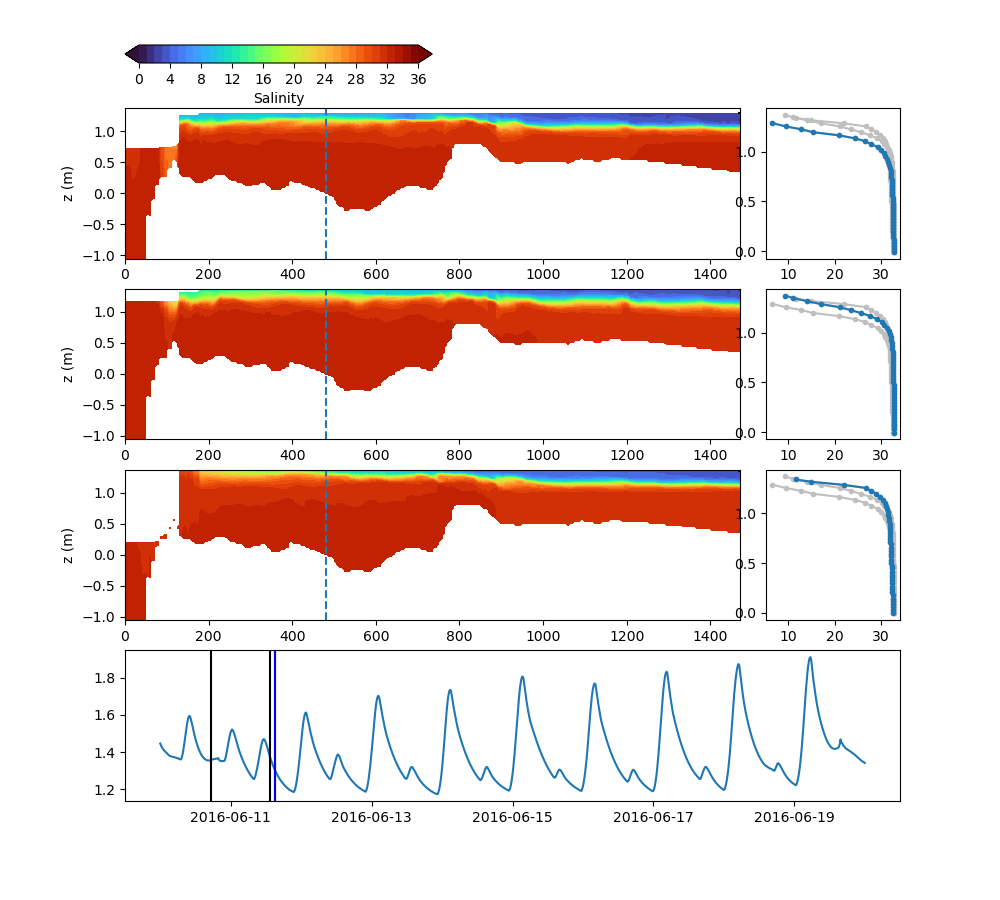

Range of salinity:  2.4445437614125716 32.9988405389439
Range of salinity:  2.5995294454519082 32.999997539378214
Range of salinity:  3.51428669062875 32.997384016140565


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


In [35]:
fig=plt.figure(figsize=(10,9))

G=gs.GridSpec(1+len(trans),5)

axs=[]
axv=ax=None
axvs=[]
for ti,t in enumerate(trans):
    ax=fig.add_subplot(G[ti,:-1],sharex=ax,sharey=ax)
    axs.append(ax)
    axv=fig.add_subplot(G[ti,-1],sharex=axv,sharey=axv)
    axvs.append(axv)

    
top_pos=axs[0].get_position()

cax=fig.add_axes( [top_pos.xmin,top_pos.ymax+0.05,0.5*top_pos.width,0.02])
    
#t=np.datetime64("2016-06-16")
t=np.datetime64("2016-06-11T15:00")
dist=475 # pull a profile from here.

V=np.linspace(0,36,37)

ttrans=[tran.isel(
        time=min(np.searchsorted(tran.time.values,t),
                 tran.dims['time']-1) )
     for tran in trans]
    

for ax,tran in zip(axs,ttrans):
    xrt.get_d_sample(tran)
    cset=xrt.contourf(tran,'salinity',V,ax=ax,cmap=turbo,extend='both')
    ax.set_ylabel('z (m)')
    xrt.contour(tran,'salinity',np.r_[33.0],ax=ax,colors='k')
    print("Range of salinity: ",float(tran['salinity'].min()),
          float(tran['salinity'].max()))

plt.colorbar(cset,cax=cax,label='Salinity',orientation='horizontal')

sampxy=None
for ax,axv,tran in zip(axs,axvs,ttrans):
    txy=np.c_[ tran.x_sample.values, tran.y_sample.values]
    if sampxy is None:
        samp=np.searchsorted(tran.d_sample.values,dist)
        sampxy=txy[samp]
    else:
        dists=utils.dist(sampxy, txy)
        samp=np.argmin(dists)
    axv.plot(tran['salinity'].isel(sample=samp),
             tran['z_ctr'].isel(sample=samp),
             marker='.')
    ax.axvline(tran.d_sample.values[samp],ls='--')
    # ghosted on other axes:
    for ax_other in axvs:
        if ax_other!=ax:
            ax_other.plot(tran['salinity'].isel(sample=samp),
                          tran['z_ctr'].isel(sample=samp),
                          color='0.75',marker='.',zorder=-1)
            

axt=fig.add_subplot(G[-1,:])
axt.plot( hiss[0].time, hiss[0]['waterlevel'].isel(stations=7),label='NCK waterlevel')

for tran in ttrans:
    axt.axvline( tran.time.values,color='k')
    
axt.axvline(t,color='b')

<IPython.core.display.Javascript object>


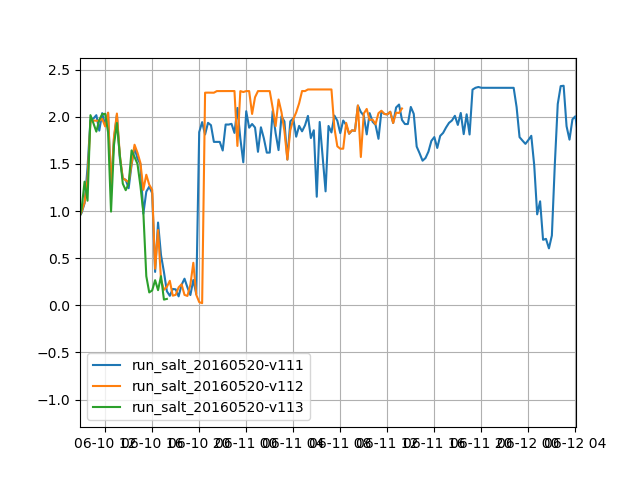

In [40]:
# Is the run with low adjacent levels having time step problems?
# Seems to be par for the course.

plt.figure()
for run_dir,his in zip(run_dirs,hiss):
    plt.plot(his.time,his.timestep,label=run_dir)
plt.legend()

In [37]:
hiss[0]

<xarray.Dataset>
Dimensions:                                  (cross_section: 20, gategens: 3, general_structures: 2, laydim: 100, laydimw: 101, nFlowElemContourPts: 4, nFlowElemWithBnd: 5705, nFlowLink: 8832, nFlowLinkPts: 2, nNetLink: 9154, nNetLinkPts: 2, station_geom_nNodes: 1028, stations: 1028, time: 961)
Coordinates:
    station_x_coordinate                     (stations) float64 ...
    station_y_coordinate                     (stations) float64 ...
    station_name                             (stations) |S64 b'pch_up' ... b'thalweg_butan_0203'
    zcoordinate_c                            (time, stations, laydim) float64 ...
    zcoordinate_w                            (time, stations, laydimw) float64 ...
    zcoordinate_wu                           (time, stations, laydimw) float64 ...
    cross_section_name                       (cross_section) |S64 ...
    general_structure_id                     (general_structures) |S64 ...
    gategen_name                             (ga